# Training Dataset Creation

In [1]:
import os
import sys
import pathlib

from PIL import Image
from PIL.Image import Resampling
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.transforms import Resize, RandomHorizontalFlip
import imagehash
import matplotlib.pyplot as plt
import pandas as pd
import torch

sys.path.insert(0, '..')

## Walk through Train Directory

In [2]:
paths = []

for (dirpath, dirnames, filenames) in os.walk('../data/Training Data'):
    for filename in filenames:
        extension = pathlib.Path(filename).suffix
        if extension == '.jpg':
            path = os.path.join(dirpath, filename)
            path = os.path.normcase(path)
            paths.append(path)
            print(path)

..\data\training data\backyard\seattle_3269390_1.jpg
..\data\training data\backyard\seattle_3269390_2.jpg
..\data\training data\backyard\seattle_3269390_3.jpg
..\data\training data\backyard\seattle_6362362_1.jpg
..\data\training data\backyard\seattle_6362362_2.jpg
..\data\training data\backyard\seattle_6424982_1.jpg
..\data\training data\backyard\seattle_6424982_2.jpg
..\data\training data\basement\seattle_9550869_1.jpg
..\data\training data\basement\seattle_9550869_2.jpg
..\data\training data\bathroom\boston_15543904_1.jpg
..\data\training data\bathroom\boston_15543904_2.jpg
..\data\training data\bathroom\boston_15843621_2.jpg
..\data\training data\bathroom\boston_1584362_1.jpg
..\data\training data\bathroom\boston_16559025_1.jpg
..\data\training data\bathroom\boston_16559025_2.jpg
..\data\training data\bathroom\boston_1696090_1.jpg
..\data\training data\bathroom\boston_1696090_2.jpg
..\data\training data\bathroom\boston_1783990_1.jpg
..\data\training data\bathroom\boston_1783990_2.jp

In [3]:
os.path.basename('..\data\training data\kitchen\seattle_5680462_4.jpg')

'seattle_5680462_4.jpg'

## Functions that Determine Label

In [4]:
def is_duplicate(path_1, path_2):
    filename_1_parts = os.path.basename(path_1).split('_')
    filename_2_parts = os.path.basename(path_2).split('_')
    # {city}_{roomid}_{match number}.jpg
    return filename_1_parts[0] == filename_2_parts[0] and filename_1_parts[1] == filename_2_parts[1]

def get_class(path_1, path_2):
    return int(is_duplicate(path_1, path_2))

In [5]:
assert is_duplicate('..\data\training data\kitchen\seattle_5680462_1.jpg', '..\data\training data\kitchen\seattle_5680462_2.jpg')

## Training Dataset Creation (Pandas)

In [6]:
def create_training_dataset(paths):
    image1s = []
    image2s = []
    classes = []
    for path1 in paths:
        for path2 in paths:
            image1s.append(path1)
            image2s.append(path2)
            classes.append(get_class(path1, path2))
    return pd.DataFrame({
        'image1': image1s,
        'image2': image2s,
        'class': classes
    })

In [7]:
train_df = create_training_dataset(paths)
train_df.shape

(398161, 3)

In [8]:
train_df.sample(20)

,image1,image2,class
146890,..\data\training data\bedroom\seattle_6424982_...,..\data\training data\living-room\boston_28542...,0
290015,..\data\training data\living-room\boston_17267...,..\data\training data\kitchen\boston_677231_2.jpg,0
191528,..\data\training data\house-exterior\boston_58...,..\data\training data\kitchen\boston_13724244_...,0
165124,..\data\training data\dining-room\seattle_1110...,..\data\training data\kitchen\seattle_9368342_...,0
310923,..\data\training data\living-room\boston_28276...,..\data\training data\living-room\boston_22327...,0
220996,..\data\training data\kitchen\boston_19670771_...,..\data\training data\bedroom\boston_32694_3.jpg,0
300413,..\data\training data\living-room\boston_23040...,..\data\training data\bedroom\boston_1315879_3...,0
13917,..\data\training data\bathroom\boston_2158285_...,..\data\training data\bathroom\seattle_278830_...,0
22041,..\data\training data\bathroom\seattle_278830_...,..\data\training data\living-room\seattle_2686...,0
323246,..\data\training data\living-room\boston_36996...,..\data\training data\bedroom\boston_5346501_1...,0


In [9]:
train_df['class'].value_counts()

0    394396
1      3765
Name: class, dtype: int64

## Upsampling Duplicate Pairs

- Add horizontal flip flag to duplicate image pairs
- Permutate horizonal flip flags for each image pair (1, 0), (0, 1) and (1, 1)

Number of duplicate pairs will increase 4x to 15,060 (3765 * 4)

In [10]:
train_df['img1_hflip'] = 0
train_df['img2_hflip'] = 0

In [11]:
duplicate_pairs_df = train_df.loc[train_df['class'] == 1].copy()
duplicate_pairs_df.shape

(3765, 5)

In [12]:
upsampled_df = pd.DataFrame()
        
for img1_hflip in [True, False]:
    for img2_hflip in [True, False]:
        temp_df = duplicate_pairs_df.copy()
        temp_df['img1_hflip'] = img1_hflip
        temp_df['img2_hflip'] = img2_hflip
        upsampled_df = pd.concat([upsampled_df, temp_df], ignore_index=True)

In [13]:
upsampled_df.loc[:, ['img1_hflip', 'img2_hflip']].drop_duplicates()

,img1_hflip,img2_hflip
0,True,True
3765,True,False
7530,False,True
11295,False,False


In [14]:
upsampled_df['class'].shape

(15060,)

## Downsampling Non-Duplicate Pairs

- Compute perceptual hash
- Find threshold and filter pairs that are similar

In [15]:
image_hash_dict = dict()

for path in paths:
    image = Image.open(path)
    image = image.resize((224, 224), resample=Resampling.BILINEAR)
    image_hash_dict[path] = imagehash.whash(image)
    
len(image_hash_dict)

631

In [16]:
def compute_similarity(img1_path, img2_path):
    return image_hash_dict[img1_path] - image_hash_dict[img2_path]

In [17]:
non_duplicate_pairs_df = train_df.loc[train_df['class'] == 0].copy()
non_duplicate_pairs_df.shape

(394396, 5)

<Axes: ylabel='Frequency'>

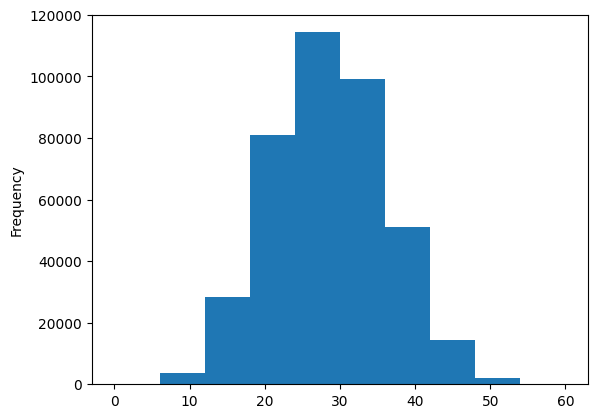

In [18]:
non_duplicate_pairs_df['similarity'] = non_duplicate_pairs_df.apply(lambda row: compute_similarity(row['image1'], 
                                                                                                   row['image2']), 
                                                                    axis=1)
non_duplicate_pairs_df['similarity'].plot(kind='hist')

In [19]:
non_duplicate_pairs_df['similarity'].value_counts().sort_index().cumsum().loc[lambda _cumsum: _cumsum > 15060].index[0]

14

In [20]:
non_duplicate_pairs_df.loc[non_duplicate_pairs_df['similarity'] <= 14].shape

(17464, 6)

## Finalise Training Dataset

In [21]:
duplicate_pairs_df = train_df.loc[train_df['class'] == 1]
duplicate_pairs_df.shape

(3765, 5)

In [22]:
non_duplicate_pairs_df = non_duplicate_pairs_df.loc[non_duplicate_pairs_df['similarity'] <= 14]
non_duplicate_pairs_df.shape

(17464, 6)

In [23]:
train_df = pd.concat([upsampled_df, non_duplicate_pairs_df], ignore_index=True).drop(['similarity'], axis=1)
train_df.head()

,image1,image2,class,img1_hflip,img2_hflip
0,..\data\training data\backyard\seattle_3269390...,..\data\training data\backyard\seattle_3269390...,1,1,1
1,..\data\training data\backyard\seattle_3269390...,..\data\training data\backyard\seattle_3269390...,1,1,1
2,..\data\training data\backyard\seattle_3269390...,..\data\training data\backyard\seattle_3269390...,1,1,1
3,..\data\training data\backyard\seattle_3269390...,..\data\training data\house-exterior\seattle_3...,1,1,1
4,..\data\training data\backyard\seattle_3269390...,..\data\training data\house-exterior\seattle_3...,1,1,1


In [24]:
train_df.sample(10)

,image1,image2,class,img1_hflip,img2_hflip
3120,..\data\training data\living-room\boston_56618...,..\data\training data\bedroom\boston_5661892_5...,1,1,1
17390,..\data\training data\bedroom\boston_18290558_...,..\data\training data\living-room\seattle_2788...,0,0,0
3838,..\data\training data\basement\seattle_9550869...,..\data\training data\kitchen\seattle_9550869_...,1,1,0
16080,..\data\training data\bedroom\boston_1315879_4...,..\data\training data\living-room\boston_28542...,0,0,0
13224,..\data\training data\house-exterior\seattle_7...,..\data\training data\bedroom\seattle_7772661_...,1,0,0
136,..\data\training data\bathroom\boston_1783990_...,..\data\training data\bedroom\boston_1783990_2...,1,1,1
8602,..\data\training data\bedroom\seattle_1686930_...,..\data\training data\bedroom\seattle_1686930_...,1,0,1
8316,..\data\training data\bedroom\boston_3699627_1...,..\data\training data\living-room\boston_36996...,1,0,1
27956,..\data\training data\living-room\boston_28655...,..\data\training data\living-room\boston_67723...,0,0,0
25943,..\data\training data\living-room\boston_13214...,..\data\training data\living-room\seattle_6361...,0,0,0


## Import `DuplicateImageDataset` Class and Compare

- Above code is ported to `DuplicateImageDataset` that inherits from `torch.utils.data.Dataset`

In [25]:
from scripts.dataset_duplicate_image import DuplicateImageDataset

In [26]:
dataset = DuplicateImageDataset('../data/Training Data')

In [27]:
len(train_df)

32524

In [28]:
assert len(dataset) == len(train_df)

In [29]:
train_df.iloc[6398]

image1        ..\data\training data\kitchen\seattle_9368342_...
image2        ..\data\training data\bedroom\seattle_9368342_...
class                                                         1
img1_hflip                                                    1
img2_hflip                                                    0
Name: 6398, dtype: object

In [30]:
dataset[6398]

(tensor([[[154, 154, 154,  ..., 171, 171, 171],
          [154, 154, 154,  ..., 171, 171, 171],
          [154, 154, 154,  ..., 171, 171, 171],
          ...,
          [178, 178, 178,  ..., 206, 205, 204],
          [178, 178, 178,  ..., 206, 206, 205],
          [178, 178, 178,  ..., 206, 206, 205]],
 
         [[122, 122, 122,  ..., 146, 146, 146],
          [122, 122, 122,  ..., 146, 146, 146],
          [122, 122, 122,  ..., 146, 146, 146],
          ...,
          [114, 114, 114,  ..., 137, 136, 135],
          [114, 114, 114,  ..., 137, 137, 136],
          [114, 114, 114,  ..., 137, 137, 136]],
 
         [[ 99,  99,  99,  ..., 124, 124, 124],
          [ 99,  99,  99,  ..., 124, 124, 124],
          [ 99,  99,  99,  ..., 124, 124, 124],
          ...,
          [ 68,  68,  68,  ...,  98,  97,  96],
          [ 68,  68,  68,  ...,  98,  98,  97],
          [ 68,  68,  68,  ...,  98,  98,  97]]], dtype=torch.uint8),
 tensor([[[162, 162, 162,  ..., 198, 198, 198],
          [162,

In [31]:
assert torch.all(torch.eq(dataset[6398][0], RandomHorizontalFlip(p=1)(read_image(train_df.iloc[6398, 0]))))

In [32]:
assert torch.all(torch.eq(dataset[6398][1], read_image(train_df.iloc[6398, 1])))

In [33]:
dataset = DuplicateImageDataset('../data/Training Data', balance_classes=False)
assert len(dataset) == (len(paths) ** 2)

In [34]:
dataset[100000]

(tensor([[[202, 207, 210,  ..., 219, 220, 223],
          [205, 209, 211,  ..., 218, 220, 222],
          [207, 209, 211,  ..., 218, 219, 222],
          ...,
          [204, 203, 202,  ..., 215, 201, 205],
          [204, 203, 202,  ..., 219, 204, 203],
          [201, 201, 200,  ..., 220, 204, 197]],
 
         [[193, 198, 201,  ..., 227, 229, 229],
          [196, 200, 202,  ..., 226, 229, 228],
          [198, 200, 202,  ..., 226, 228, 228],
          ...,
          [167, 166, 165,  ..., 227, 213, 217],
          [167, 166, 165,  ..., 231, 216, 215],
          [166, 164, 163,  ..., 232, 216, 209]],
 
         [[184, 189, 192,  ..., 229, 228, 229],
          [187, 191, 193,  ..., 228, 228, 228],
          [189, 191, 193,  ..., 228, 227, 228],
          ...,
          [138, 137, 136,  ..., 225, 211, 215],
          [138, 137, 136,  ..., 229, 214, 213],
          [138, 135, 134,  ..., 230, 214, 207]]], dtype=torch.uint8),
 tensor([[[ 10,  13,  16,  ...,  23,  31,  37],
          [ 17,

## Wrap `DuplicateImageDataset` in DataLoader

In [35]:
train_dataset = DuplicateImageDataset('../data/Training Data', transforms=[Resize((960, 1280), antialias=True)])
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [36]:
train_img_1s, train_img_2s, train_labels = next(iter(train_dataloader))
print('Image 1s shape:', train_img_1s.size())
print('Image 2s shape:', train_img_2s.size())
print('Labels shape:', train_labels.size())

Image 1s shape: torch.Size([64, 3, 960, 1280])
Image 2s shape: torch.Size([64, 3, 960, 1280])
Labels shape: torch.Size([64])
